<a href="https://colab.research.google.com/github/el-moudni-hicham/brain-mri-segmentation-kmeans-pyspark/blob/main/kmeans_brain_mri_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
# Import the required Python dependencies
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import numpy as np
import pandas as pd
from skimage import io
from skimage import img_as_float

<ipython-input-68-783e0186da2c>:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [11]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,014 kB]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,283 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/m

In [12]:
import os
import sys
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [13]:
! ls /content/

sample_data  spark-3.0.1-bin-hadoop2.7	spark-3.0.1-bin-hadoop2.7.tgz


In [14]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.0.1-bin-hadoop2.7'

In [15]:
import pyspark
from pyspark.sql import SparkSession

In [ ]:
# Create the Spark session
# spark://hichamdesktop.:7077
#spark = SparkSession.builder.master("spark://hichamdesktop.:7077").appName("K-Means Clustering - MRI").getOrCreate()

In [84]:
ss = SparkSession \
       .builder \
       .appName("MRI") \
       .master("local[*]") \
       .getOrCreate()

ss

/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:304: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


Text(0.5, 1.0, 'MRI Scan of a HEALTHY Brain\n')

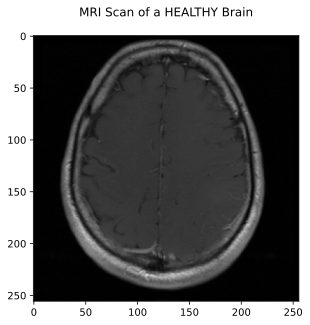

In [69]:
# Load the MRI scan of HEALTHY brain
mri_hb = io.imread('mri-healthy-brain.png')
mri_hb_plot = plt.imshow(mri_hb, cmap='gray')
plt.title("MRI Scan of a HEALTHY Brain\n")

In [19]:
#mri_healthy_brain_image[10:13] # extract the row 10 to row 12

In [20]:
mri_hb

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [21]:
# Convert our Training MRI Scan into a Matrix of pixel intensity values between 0 and 1
mri_hb_matrix = img_as_float(mri_hb)
print("Healthy MRI Scan - MATRIX of Pixel Intensity Values: \n")
print(mri_hb_matrix)
print("\nHealthy MRI Scan - MATRIX Dimensions (width x height in px): \n")
print(mri_hb_matrix.shape)

Healthy MRI Scan - MATRIX of Pixel Intensity Values: 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Healthy MRI Scan - MATRIX Dimensions (width x height in px): 

(256, 256)


In [22]:
# Convert the Matrix into a Flattened Vector i.e. Matrix of dimensions 1 x N
mri_hb_2d_array = np.array(mri_hb_matrix).astype(float)
mri_hb_1d_array = mri_hb_2d_array.ravel()
mri_hb_vector = np.matrix(mri_hb_1d_array)

print("Healthy MRI Scan - Flattened Vector i.e. Matrix of Dimensions 1 x N: \n")
print(mri_hb_vector)
print("\nHealthy MRI Scan - Flattened Vector Dimensions: \n")
print(mri_hb_vector.shape)

Healthy MRI Scan - Flattened Vector i.e. Matrix of Dimensions 1 x N: 

[[0. 0. 0. ... 0. 0. 0.]]

Healthy MRI Scan - Flattened Vector Dimensions: 

(1, 65536)


In [23]:
# Calculate Transposer of the Flattened Vector
mri_hb_vector_transposed = mri_hb_vector.reshape(mri_hb_vector.shape[1], mri_hb_vector.shape[0])

print("Healthy MRI Scan - Transposed Vector i.e. Matrix of Dimensions N x 1: ")
print(mri_hb_vector_transposed)
print("\nHealthy MRI Scan - Transposed Vector Dimensions: \n")
print(mri_hb_vector_transposed.shape)

Healthy MRI Scan - Transposed Vector i.e. Matrix of Dimensions N x 1: 
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

Healthy MRI Scan - Transposed Vector Dimensions: 

(65536, 1)


In [30]:
df_ = pd.DataFrame(mri_hb_vector_transposed, columns=['pixel_intensity'])

In [31]:
df_

,pixel_intensity
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
65531,0.0
65532,0.0
65533,0.0
65534,0.0


In [75]:
# Convert the Flattened Vector into a Spark DataFrame where each Row corresponds to a single pixel intensity value
#df = ss.createDataFrame(data=mri_hb_vector_transposed, schema = ['pixel_intensity'])

mri_hb_df = ss.createDataFrame(df_)
mri_hb_df.show()
mri_hb_df.dtypes

/content/spark-3.0.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:327: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


AttributeError: ignored

In [35]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import DenseVector

In [36]:
# Convert pixel_intensity to vectors
feature_columns = ['pixel_intensity']
vector_assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')

In [39]:
print("Healthy MRI Scan - Pixel Intensity Feature Vectors: \n")
#vector_assembler_test = vector_assembler.transform(mri_hb_df).select('pixel_intensity','features')
mri_hb_features_df = vector_assembler.transform(mri_hb_df).select('features')
mri_hb_features_df.show()
mri_hb_features_df.dtypes

Healthy MRI Scan - Pixel Intensity Feature Vectors: 

+--------+
|features|
+--------+
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
+--------+
only showing top 20 rows



[('features', 'vector')]

In [45]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()

In [61]:
# Train a K-Means Clustering Model based on the Pixel Intensity Feature Vectors of a Healthy MRI Brain Scan
k = 5
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
kmeans_model = kmeans.fit(mri_hb_features_df)
kmeans_centers = kmeans_model.clusterCenters()
print("Healthy MRI Scan - K-Means Cluster Centers: \n")
for center in kmeans_centers:
    print(center)

Healthy MRI Scan - K-Means Cluster Centers: 

[2.5526304e-07]
[6.77274967e-06]
[4.70425315e-06]
[1.68645636e-05]
[1.1518666e-05]


In [62]:
# Assign Pixels to Clusters in the HEALTHY MRI Brain Scan Image and visualise these K Clusters
mri_hb_clusters_df = kmeans_model.transform(mri_hb_features_df).select('features', 'prediction')
print("Healthy MRI Scan - Pixels mapped to 1 ... K Clusters (K = %d): \n" % k)
mri_hb_clusters_df.show()

Healthy MRI Scan - Pixels mapped to 1 ... K Clusters (K = 5): 

+--------+----------+
|features|prediction|
+--------+----------+
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
|   [0.0]|         0|
+--------+----------+
only showing top 20 rows




Healthy MRI Scan - Cluster Visualisation: 



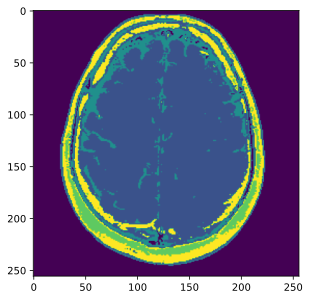

In [71]:
print("\nHealthy MRI Scan - Cluster Visualisation: \n")
mri_hb_clusters_matrix = mri_hb_clusters_df.select("prediction").toPandas()\
                        .values.reshape(mri_hb_matrix.shape[0], mri_hb_matrix.shape[1]) # (256, 256)
plt.imshow(mri_hb_clusters_matrix)
#plt.title("MRI Scan of a HEALTHY Brain mapped to K Clusters (K = %d)\n" % k)
plt.show()

/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:304: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


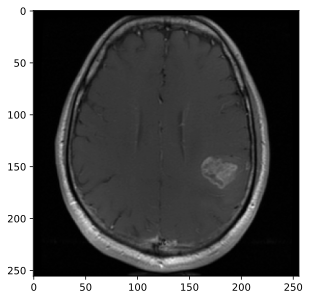

In [72]:
# Load an MRI Scan belonging to another Brain to Test our K-Means Clustering Model
mri_test_brain_image = io.imread('mri-test-brain.png')
mri_test_brain_image_plot = plt.imshow(mri_test_brain_image, cmap='gray')
#plt.title("MRI Scan of another Brain to TEST our Unsupervised K-Means Clustering Model\n")

/content/spark-3.0.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:327: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


\Test MRI Scan - Cluster Visualisation: 



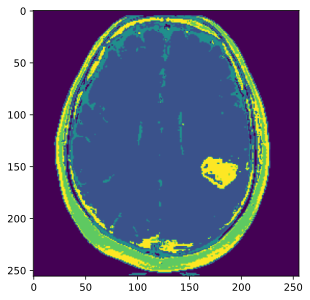

In [73]:
# Apply the trained K-Means Clustering Model to the TEST MRI Scan

mri_test_brain_matrix = img_as_float(mri_test_brain_image)
mri_test_brain_2d_array = np.array(mri_test_brain_matrix).astype(float)
mri_test_brain_1d_array = mri_test_brain_2d_array.ravel()
mri_test_brain_vector = np.matrix(mri_test_brain_1d_array)
mri_test_brain_vector_transposed = mri_test_brain_vector.reshape(
    mri_test_brain_vector.shape[1], mri_test_brain_vector.shape[0])
mri_test_brain_df = ss.createDataFrame(pd.DataFrame(mri_test_brain_vector_transposed, columns=['pixel_intensity']))
mri_test_brain_features_df = vector_assembler.transform(mri_test_brain_df).select('features')

mri_test_brain_clusters_df = kmeans_model.transform(mri_test_brain_features_df).select('features', 'prediction')
print("\Test MRI Scan - Cluster Visualisation: \n")
mri_test_brain_clusters_matrix = mri_test_brain_clusters_df.select("prediction").toPandas().values.reshape(
    mri_test_brain_matrix.shape[0], mri_test_brain_matrix.shape[1])
plt.imshow(mri_test_brain_clusters_matrix)
#plt.title("MRI Scan of a TEST Brain mapped to the previously TRAINED K Clusters (K = %d) showing potentially cancerous cells\n" % k)
plt.show()

In [77]:
# Stop the Spark Session
ss.stop()